In [1]:
import modules.models.model_mobilenetv2 as my_model
import modules.models.model_mobilenetv2_1M as my_model_1M

import modules.models.model_mobilenetv2_small as my_model_small
import modules.models.model_mobilenetv2_mini as my_model_mini

import modules.model_mobilenetv2_mini_Resnet as my_model_mini_resnet
import modules.model_mobilenetv2_mini_Resnet_160 as my_model_mini_resnet_160

import modules.model_mobilenetv2_mini_Resnet_Sparse as my_model_mini_resnet_sparse

import modules.model_mobilenetv2_v3_mini_Resnet_last_stage as my_model_mini_resnet_v2_v3

import numpy as np
import torch
from torchinfo import summary

import matplotlib.pyplot as plt

# Profiler: torchprofile

In [2]:
from torchprofile import profile_macs

# Profiler: torchlop

In [3]:
from torchlop import profile

In [4]:
def get_macs_and_params_per_layer(model, inp_shape = (1, 3, 224, 224), device = 'cpu'):

    dummy_inp = torch.randn(inp_shape).to(device)
    macs, params, layer_infos = profile(model, inputs=(dummy_inp, ))

    print('Total MACs of {}: {:.4g} M'.format(model.__class__.__name__, macs / 1e6))
    print('Total params of {}: {}'.format(model.__class__.__name__, params))

    macs_layer = {}
    params_layer = {}

    conv_idx = 0
    linear_idx = 0
    
    for i, k in enumerate(layer_infos.keys()):
        layer_type = layer_infos[k]["type"]
        layer_ops = layer_infos[k]["ops"]
        layer_params = layer_infos[k]["params"]
        if layer_ops != 0 and layer_type != "BatchNorm2d":
            if layer_type == "Conv2d": 
                macs_layer.update({layer_type + '_' + str(conv_idx): layer_ops})   
                params_layer.update({layer_type + '_' + str(conv_idx): layer_params}) 
                conv_idx += 1
            elif layer_type == "Linear":
                macs_layer.update({layer_type + '_' + str(linear_idx): layer_ops}) 
                params_layer.update({layer_type + '_' + str(linear_idx): layer_params})  
                linear_idx += 1 
            else:
                macs_layer.update({layer_type: layer_ops})
                params_layer.update({layer_type: layer_params})

    return macs_layer, params_layer

## Plot results

In [5]:
def plot_results(res_layer, res_type: str):
    fig, ax = plt.subplots(figsize=(8,3))

    layers_name = list(res_layer.keys())
    layer_res = list(res_layer.values())
    
    rects = ax.bar(layers_name, layer_res)
    ax.bar_label(rects, padding=3, fontsize=7)
    if res_type == "macs":
        ylabel = "MACs (M)"
        title = "MACs per layer (M)"
    elif res_type == "params":
        ylabel = "#Params"  
        title = "#Params per layer"
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(np.arange(len(layers_name)), layers_name, rotation=90, fontsize=8)
    
    plt.show()

# Models

In [6]:
model = my_model.MobileNetV2().to('cpu')
model_1M = my_model_1M.MobileNetV2_1M(width_mult=1.).to('cpu')

model_small = my_model_small.MobileNetV2_SMALL().to('cpu')
model_mini = my_model_mini.MobileNetV2_MINI().to('cpu')

In [7]:
model_mini_resnet = my_model_mini_resnet.MobileNetV2_MINI_RESNET().to('cpu')
model_mini_resnet_160 = my_model_mini_resnet_160.MobileNetV2_MINI_RESNET_160().to('cpu')
model_mini_resnet_sparse = my_model_mini_resnet_sparse.MobileNetV2_MINI_RESNET_SPARSE().to('cpu')

model_wmult_01 = my_model.MobileNetV2(width_mult=0.1).to('cpu')

In [8]:
model_mini_resnet_v2_v3 = my_model_mini_resnet_v2_v3.MobileNetV2_MINI_RESNET_V3().to('cpu')

In [9]:
model.eval();
model_1M.eval();
model_small.eval();
model_mini.eval();

In [10]:
model_mini_resnet.eval();
model_mini_resnet_160.eval();

model_wmult_01.eval();

In [11]:
model_mini_resnet_v2_v3.eval();

### Check Device

In [12]:
# for name, p in model_mini_resnet_160.named_parameters():
#     print(name, p.device)

features.0.0.weight cpu
features.0.1.weight cpu
features.0.1.bias cpu
features.1.conv.0.weight cpu
features.1.conv.1.weight cpu
features.1.conv.1.bias cpu
features.1.conv.3.weight cpu
features.1.conv.4.weight cpu
features.1.conv.4.bias cpu
features.2.conv.0.weight cpu
features.2.conv.1.weight cpu
features.2.conv.1.bias cpu
features.2.conv.3.weight cpu
features.2.conv.4.weight cpu
features.2.conv.4.bias cpu
features.2.conv.6.weight cpu
features.2.conv.7.weight cpu
features.2.conv.7.bias cpu
features.3.conv.0.weight cpu
features.3.conv.1.weight cpu
features.3.conv.1.bias cpu
features.3.conv.3.weight cpu
features.3.conv.4.weight cpu
features.3.conv.4.bias cpu
features.3.conv.6.weight cpu
features.3.conv.7.weight cpu
features.3.conv.7.bias cpu
features.4.conv.0.weight cpu
features.4.conv.1.weight cpu
features.4.conv.1.bias cpu
features.4.conv.3.weight cpu
features.4.conv.4.weight cpu
features.4.conv.4.bias cpu
features.4.conv.6.weight cpu
features.4.conv.7.weight cpu
features.4.conv.7.bias

## MobileNetV2

### Profile

In [13]:
inputs = torch.randn(1, 3, 224, 224)

macs = profile_macs(model, inputs)
print('{}: {:.4g} M'.format(model.__class__.__name__, macs / 1e6))

MobileNetV2: 245.9 M


In [14]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model)

Total MACs of MobileNetV2: 251.8 M
Total params of MobileNetV2: 1719042.0


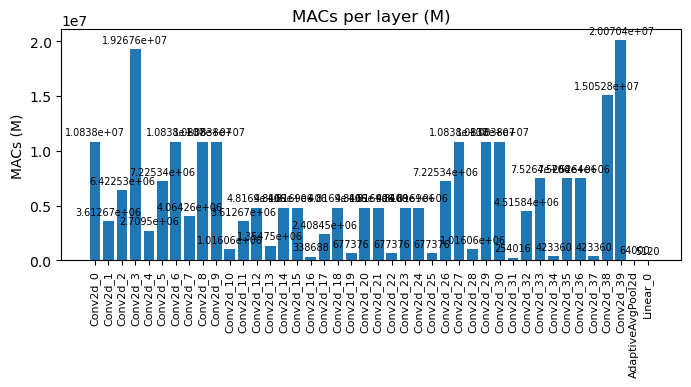

In [15]:
plot_results(macs_mbnet, res_type="macs")

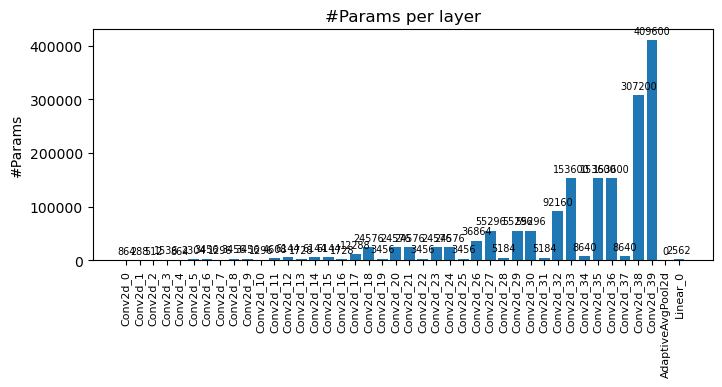

In [16]:
plot_results(params_mbnet, res_type="params")

### Summary

In [17]:
print(summary(model, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2                              [1, 2]                    --
├─Sequential: 1-1                        [1, 320, 7, 7]            --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4              [1, 16, 112, 112]         896
│    └─InvertedBlock: 2-3                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 24, 56, 56]           5,136
│    └─InvertedBlock: 2-4                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 24, 56, 56]           8,832
│    └─InvertedBlock: 2-5                [1, 32, 28, 28]           --
│    │ 

In [18]:
# model

## MobileNetV2 1M

In [19]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_1M)

Total MACs of MobileNetV2_1M: 172.3 M
Total params of MobileNetV2_1M: 1078274.0


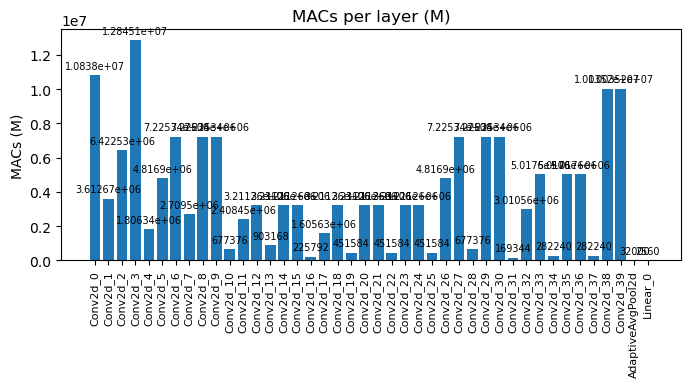

In [20]:
plot_results(macs_mbnet, res_type="macs")

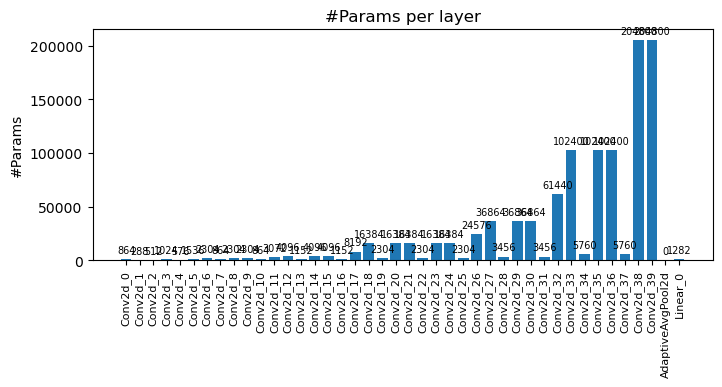

In [21]:
plot_results(params_mbnet, res_type="params")

In [22]:
print(summary(model_1M, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_1M                           [1, 2]                    --
├─Sequential: 1-1                        [1, 320, 7, 7]            --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 16, 112, 112]         --
│    │    └─Sequential: 3-4              [1, 16, 112, 112]         896
│    └─InvertedBlock: 2-3                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 24, 56, 56]           3,440
│    └─InvertedBlock: 2-4                [1, 24, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 24, 56, 56]           5,904
│    └─InvertedBlock: 2-5                [1, 32, 28, 28]           --
│    │ 

## MobileNetV2 Small

In [23]:
print(summary(model_small, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_SMALL                        [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           1,216
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           2,912
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │ 

In [24]:
# model_small

## MobileNetV2 Mini

In [25]:
print(summary(model_mini, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI                         [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           624
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │   

In [26]:
# model_mini

# Width Mult = 0.1

Not the original one, because I modified the cfg inside the model, reducing repetitions of blocks

In [27]:
print(summary(model_wmult_01, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2                              [1, 2]                    --
├─Sequential: 1-1                        [1, 32, 7, 7]             --
│    └─Sequential: 2-1                   [1, 4, 112, 112]          --
│    │    └─Conv2d: 3-1                  [1, 4, 112, 112]          108
│    │    └─BatchNorm2d: 3-2             [1, 4, 112, 112]          8
│    │    └─ReLU: 3-3                    [1, 4, 112, 112]          --
│    └─InvertedBlock: 2-2                [1, 4, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 4, 112, 112]          68
│    └─InvertedBlock: 2-3                [1, 4, 56, 56]            --
│    │    └─Sequential: 3-5              [1, 4, 56, 56]            512
│    └─InvertedBlock: 2-4                [1, 4, 56, 56]            --
│    │    └─Sequential: 3-6              [1, 4, 56, 56]            512
│    └─InvertedBlock: 2-5                [1, 4, 28, 28]            --
│    │    └─S

# Resnet

## Model 224

In [28]:
inputs = torch.randn(1, 3, 224, 224)

macs = profile_macs(model_mini_resnet, inputs)
print('{}: {:.4g} M'.format(model_mini_resnet.__class__.__name__, macs / 1e6))

MobileNetV2_MINI_RESNET: 43.85 M


In [29]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_mini_resnet)

Total MACs of MobileNetV2_MINI_RESNET: 45.91 M
Total params of MobileNetV2_MINI_RESNET: 68882.0


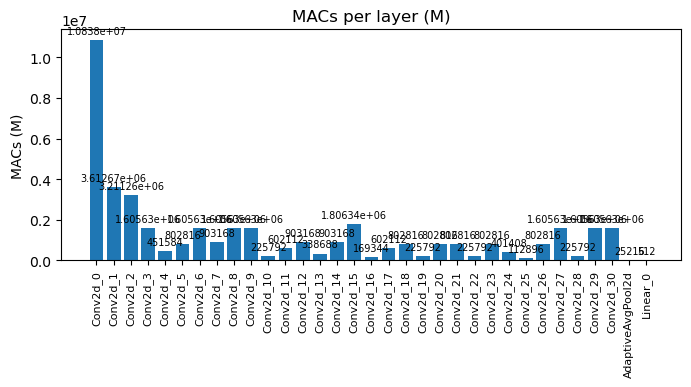

In [30]:
plot_results(macs_mbnet, res_type="macs")

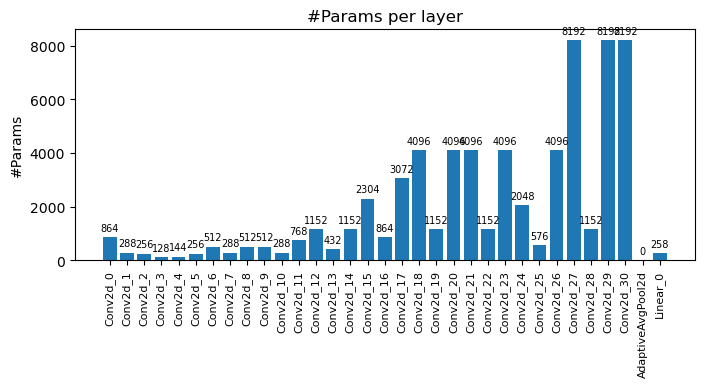

In [31]:
plot_results(params_mbnet, res_type="params")

In [32]:
print(summary(model_mini_resnet, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI_RESNET                  [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           624
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │   

## Model 224 Sparse

In [33]:
inputs = torch.randn(1, 3, 224, 224)

macs = profile_macs(model_mini_resnet_sparse, inputs)
print('{}: {:.4g} M'.format(model_mini_resnet_sparse.__class__.__name__, macs / 1e6))

MobileNetV2_MINI_RESNET_SPARSE: 39.23 M


In [34]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_mini_resnet_sparse)

Total MACs of MobileNetV2_MINI_RESNET_SPARSE: 41.09 M
Total params of MobileNetV2_MINI_RESNET_SPARSE: 68498.0


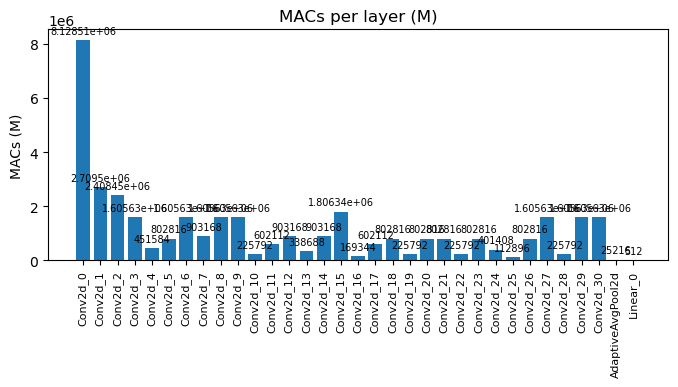

In [35]:
plot_results(macs_mbnet, res_type="macs")

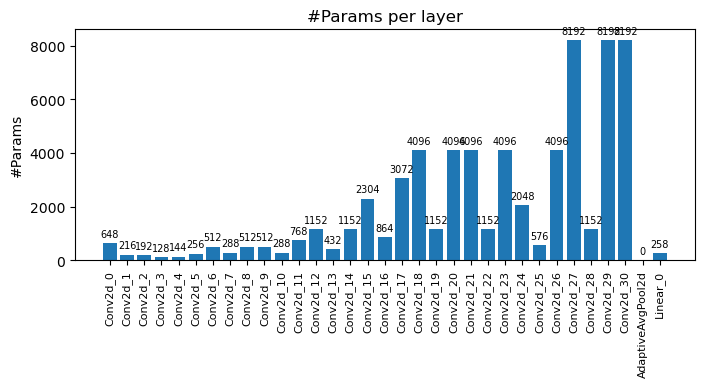

In [36]:
plot_results(params_mbnet, res_type="params")

In [37]:
print(summary(model_mini_resnet_sparse, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI_RESNET_SPARSE           [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 24, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 24, 112, 112]         648
│    │    └─BatchNorm2d: 3-2             [1, 24, 112, 112]         48
│    │    └─ReLU: 3-3                    [1, 24, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          472
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           624
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │   

## Model 160

In [38]:
inp_shape_160 = (1, 3, 160, 160)
print(summary(model_mini_resnet_160, input_size=inp_shape_160))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI_RESNET_160              [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 10, 10]           --
│    └─Sequential: 2-1                   [1, 32, 80, 80]           --
│    │    └─Conv2d: 3-1                  [1, 32, 80, 80]           864
│    │    └─BatchNorm2d: 3-2             [1, 32, 80, 80]           64
│    │    └─ReLU: 3-3                    [1, 32, 80, 80]           --
│    └─InvertedBlock: 2-2                [1, 8, 80, 80]            --
│    │    └─Sequential: 3-4              [1, 8, 80, 80]            624
│    └─InvertedBlock: 2-3                [1, 16, 40, 40]           --
│    │    └─Sequential: 3-5              [1, 16, 40, 40]           624
│    └─InvertedBlock: 2-4                [1, 16, 40, 40]           --
│    │    └─Sequential: 3-6              [1, 16, 40, 40]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 20, 20]           --
│    │   

In [39]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_mini_resnet_160, inp_shape_160, 'cuda')

Total MACs of MobileNetV2_MINI_RESNET_160: 23.42 M
Total params of MobileNetV2_MINI_RESNET_160: 68882.0


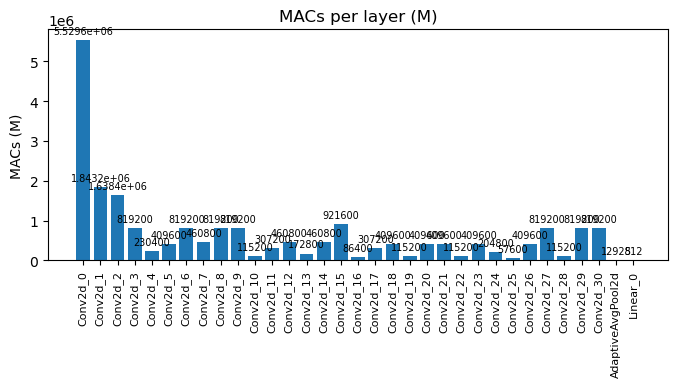

In [40]:
plot_results(macs_mbnet, res_type="macs")

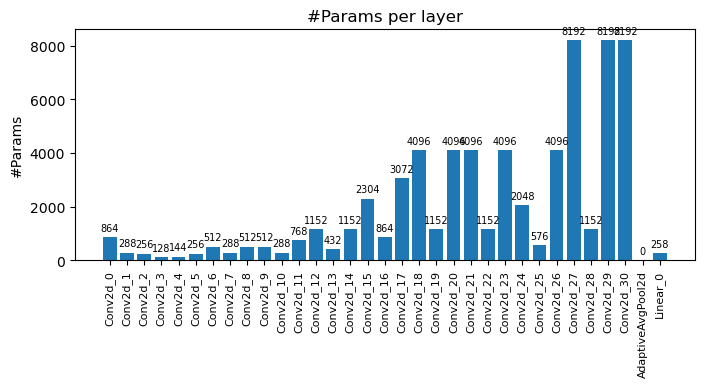

In [41]:
plot_results(params_mbnet, res_type="params")

## Model 112

In [42]:
inp_shape_112 = (1, 3, 112, 112)
print(summary(model_mini_resnet_160, input_size=inp_shape_112))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI_RESNET_160              [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 7, 7]             --
│    └─Sequential: 2-1                   [1, 32, 56, 56]           --
│    │    └─Conv2d: 3-1                  [1, 32, 56, 56]           864
│    │    └─BatchNorm2d: 3-2             [1, 32, 56, 56]           64
│    │    └─ReLU: 3-3                    [1, 32, 56, 56]           --
│    └─InvertedBlock: 2-2                [1, 8, 56, 56]            --
│    │    └─Sequential: 3-4              [1, 8, 56, 56]            624
│    └─InvertedBlock: 2-3                [1, 16, 28, 28]           --
│    │    └─Sequential: 3-5              [1, 16, 28, 28]           624
│    └─InvertedBlock: 2-4                [1, 16, 28, 28]           --
│    │    └─Sequential: 3-6              [1, 16, 28, 28]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 14, 14]           --
│    │   

In [43]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_mini_resnet_160, inp_shape_112, 'cuda')

Total MACs of MobileNetV2_MINI_RESNET_160: 11.48 M
Total params of MobileNetV2_MINI_RESNET_160: 68882.0


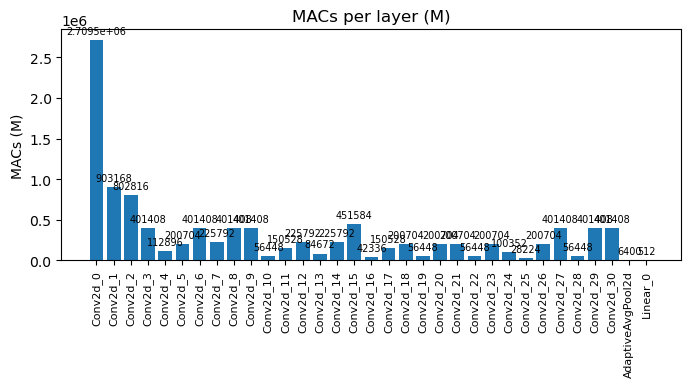

In [44]:
plot_results(macs_mbnet, res_type="macs")

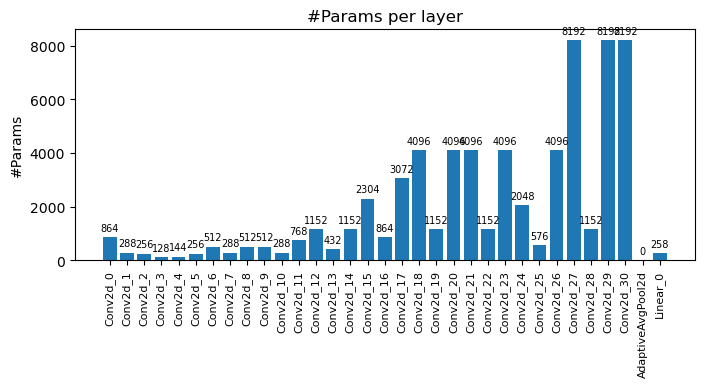

In [45]:
plot_results(params_mbnet, res_type="params")

## Last Stage

In [46]:
inputs = torch.randn(1, 3, 224, 224)

macs = profile_macs(model_mini_resnet_v2_v3, inputs)
print('{}: {:.4g} M'.format(model_mini_resnet_v2_v3.__class__.__name__, macs / 1e6))

MobileNetV2_MINI_RESNET_V3: 43.45 M


In [47]:
macs_mbnet, params_mbnet = get_macs_and_params_per_layer(model_mini_resnet_v2_v3)

Total MACs of MobileNetV2_MINI_RESNET_V3: 45.5 M
Total params of MobileNetV2_MINI_RESNET_V3: 79314.0


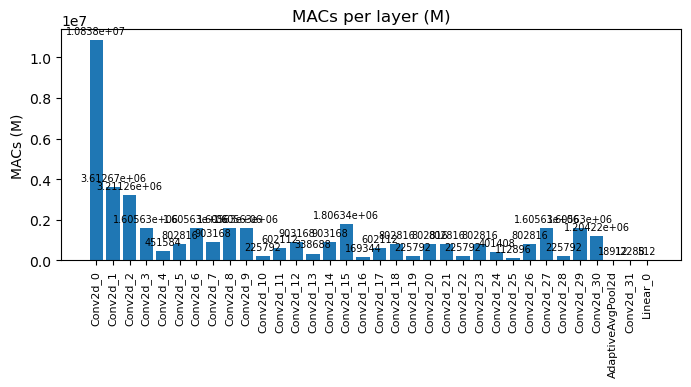

In [48]:
plot_results(macs_mbnet, res_type="macs")

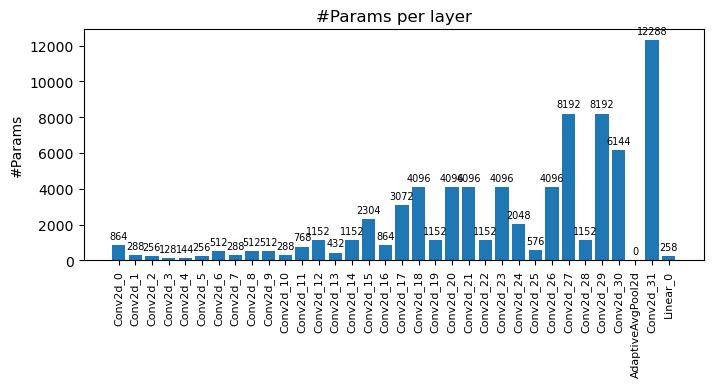

In [49]:
plot_results(params_mbnet, res_type="params")

In [50]:
print(summary(model_mini_resnet_v2_v3, input_size=(1, 3, 224, 224)))

Layer (type:depth-idx)                   Output Shape              Param #
MobileNetV2_MINI_RESNET_V3               [1, 2]                    --
├─Sequential: 1-1                        [1, 64, 14, 14]           --
│    └─Sequential: 2-1                   [1, 32, 112, 112]         --
│    │    └─Conv2d: 3-1                  [1, 32, 112, 112]         864
│    │    └─BatchNorm2d: 3-2             [1, 32, 112, 112]         64
│    │    └─ReLU: 3-3                    [1, 32, 112, 112]         --
│    └─InvertedBlock: 2-2                [1, 8, 112, 112]          --
│    │    └─Sequential: 3-4              [1, 8, 112, 112]          624
│    └─InvertedBlock: 2-3                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-5              [1, 16, 56, 56]           624
│    └─InvertedBlock: 2-4                [1, 16, 56, 56]           --
│    │    └─Sequential: 3-6              [1, 16, 56, 56]           1,472
│    └─InvertedBlock: 2-5                [1, 24, 28, 28]           --
│    │   